In [1]:
# Copyright (c) 2024 Qualcomm Technologies, Inc.
# All Rights Reserved.

import contextlib
import time
from collections.abc import Callable

import torch
import torch.utils.benchmark
from diffusers import DDIMScheduler, StableDiffusionPipeline

from clockwork import ClockworkWrapper

# NOTE 1: PATH_CACHE will likely be different on your machine, feel free to edit
# NOTE 2: this notebook was ran on a machine with a NVIDIA GeForce RTX 3080

PATH_CACHE = "/local/mnt/workspace/.cache/huggingface"
GUIDANCE_SCALE = 7.5
SEED = 174785024

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")


@contextlib.contextmanager
def timing(description: str) -> None:
    """
    Context manager allowing to time a certain block of code.

    Parameters
    ----------
    description : str
        Describe what is being timed for prettier output in stdout.

    """
    start = time.time()
    print(f"{description}... ", end="")
    yield
    elapsed_time = time.time() - start
    print(f"{elapsed_time:.2f}s")


def benchmark_torch_function(f: Callable, *args, **kwargs) -> float:
    """
    Benchmark torch function using torch utils benchmark which, while based
    on timeit.Timer, implements a few key features to get a more precise
    measurement. See the docstring of benchmark function in PyTorch documentation
    here for details: https://pytorch.org/docs/stable/benchmark_utils.html

    Function obtained written by sayakpaul github user, taken from a gist at: 
    https://gist.github.com/sayakpaul/27aec6bca7eb7b0e0aa4112205850335

    Parameters
    ----------
    f : function
        The function to time.
    *args : list
        Argument list to pass to the function f.
    **kwargs : dict
        Keyword argument to pass to the function f.

    Returns
    -------
    duration : float
        Function evaluation duration (typically averaged over a few runs).

    """
    t0 = torch.utils.benchmark.Timer(
        stmt="f(*args, **kwargs)", globals={"args": args, "kwargs": kwargs, "f": f}
    )
    return round(t0.blocked_autorange(min_run_time=1).mean, 2)

[2024-01-16 16:40:58,640] [INFO] [real_accelerator.py:133:get_accelerator] Setting ds_accelerator to cuda (auto detect)


## 1. Initialize Stable Diffusion 1.5 diffusers pipeline

In [2]:
MODEL_ID = "runwayml/stable-diffusion-v1-5"
pipeline = StableDiffusionPipeline.from_pretrained(
    MODEL_ID,
    torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32,
    cache_dir=PATH_CACHE,
)
pipeline = pipeline.to(device)
pipeline.scheduler = DDIMScheduler.from_pretrained(MODEL_ID, subfolder="scheduler")
pipeline.scheduler.set_timesteps(50, device=device)

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


## 2. Running DDIM sampling w/o clockwork

Generating image without clockwork... 

  0%|          | 0/50 [00:00<?, ?it/s]

4.17s


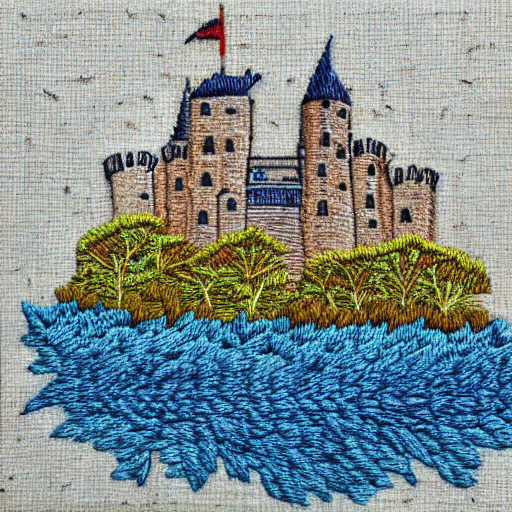

In [3]:
PROMPT = "an embroidery of a castle"
with timing("Generating image without clockwork"):
    image = pipeline(
        PROMPT,
        generator=torch.Generator(device=device).manual_seed(SEED),
        guidance_scale=GUIDANCE_SCALE,
    ).images[0]
image

In [4]:
benchmark_torch_function(
    pipeline,
    PROMPT,
    generator=torch.Generator(device=device).manual_seed(SEED),
    guidance_scale=GUIDANCE_SCALE,
)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

3.01

## 3. Running DDIM sampling w/ clockwork

In [5]:
pipeline.unet = ClockworkWrapper(pipeline.unet, clock=4)

Generating image with clockwork... 

  0%|          | 0/50 [00:00<?, ?it/s]

1.77s


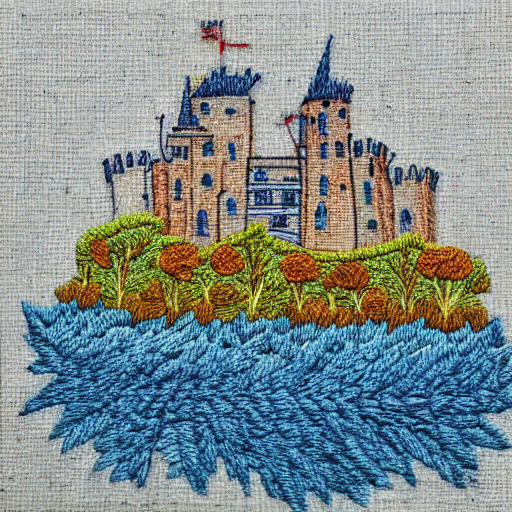

In [6]:
with timing("Generating image with clockwork"):
    image = pipeline(
        PROMPT,
        generator=torch.Generator(device=device).manual_seed(SEED),
        guidance_scale=GUIDANCE_SCALE,
    ).images[0]
image

In [7]:
benchmark_torch_function(
    pipeline,
    PROMPT,
    generator=torch.Generator(device=device).manual_seed(SEED),
    guidance_scale=GUIDANCE_SCALE,
)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

1.75

Sampling time went down **from 2.98s to 1.74s (-42%) on a 3080** while the perceptual quality remains close to the original!